In [1]:
import matplotlib 
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
from py2neo import Graph
graph = Graph("bolt://localhost:7687", user='neo4j', password='newPassword')
import time
import glob
import os

In [3]:
neo4j_query="""
MATCH (c:Client)
WHERE EXISTS(c.client_link_community_1904) 
RETURN COUNT(c.client_link_community_1904) as membercount, c.client_link_community_1904 as client_link_community_1904
ORDER BY membercount ASC;
"""

#### Community 9919
look at the retail spend of client community 9919 and use a greater than 2% cut-off of total spend:

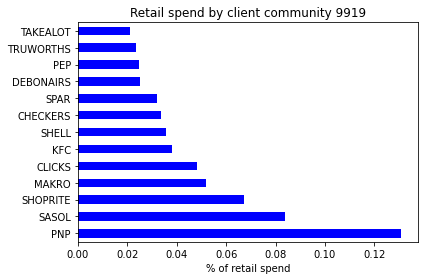

In [6]:
neo4j_query="""
MATCH (c:Client {client_link_community_1904:9919})-[t:TRANSACTED_AT]-(m:Merchant)
RETURN c.dedupestatic as dedupestatic, 
t.transactionamount as transactionamount, t.transactioncount as transactioncount,m.franchisename as franchisename,
m.companyname as companyname
ORDER BY transactionamount ASC;
"""

client_link_community_1904_9919_df=graph.run(neo4j_query).to_data_frame()

client_link_community_1904_9919_df

df_9919=client_link_community_1904_9919_df.pivot_table(index=['dedupestatic'],fill_value=0,values=['transactionamount'],columns=['companyname'])

df_9919.reset_index(inplace=True)
df_9919.set_index('dedupestatic',inplace=True)

sf=df_9919.sum(axis=0)/sum(df_9919.sum(axis=0)) 

sf.sort_values(inplace=True,ascending=False)

sf_df=sf.to_frame()

sf_df.reset_index(inplace=True)

sf_df.drop(columns=['level_0'],inplace=True)
sf_df.rename(columns={0:'9919_signature_spend'},inplace=True)

sf_df.sort_values(by='9919_signature_spend',ascending=False,inplace=True)

sf_df.set_index('companyname',inplace=True)

ax=sf_df[sf_df['9919_signature_spend']>0.02].plot.barh(title='Retail spend by client community 9919',
                                                       legend=None,
                                                      color='b')
ax.set_xlabel("% of retail spend")
ax.set_ylabel("")
plt.tight_layout()
fig = ax.get_figure()
fig.savefig('/media/lnr-ai/christo/github_repos/graphing/img/9919_signature_spend.png')
df=sf_df.copy()

#### Community 7819

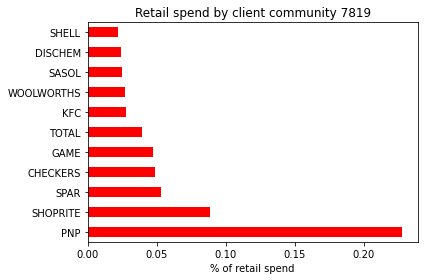

In [7]:
neo4j_query="""
MATCH (c:Client {client_link_community_1904:7819})-[t:TRANSACTED_AT]-(m:Merchant)
RETURN c.dedupestatic as dedupestatic, 
t.transactionamount as transactionamount, t.transactioncount as transactioncount,m.franchisename as franchisename,
m.companyname as companyname
ORDER BY transactionamount ASC;
"""

client_link_community_1904_7819_df=graph.run(neo4j_query).to_data_frame()

df_7819=client_link_community_1904_7819_df.pivot_table(index=['dedupestatic'],fill_value=0,values=['transactionamount'],columns=['companyname'])

df_7819.reset_index(inplace=True)
df_7819.set_index('dedupestatic',inplace=True)

sf=df_7819.sum(axis=0)/sum(df_7819.sum(axis=0)) 

sf.sort_values(inplace=True,ascending=False)

sf_df=sf.to_frame()

sf_df.reset_index(inplace=True)

sf_df.drop(columns=['level_0'],inplace=True)
sf_df.rename(columns={0:'7819_signature_spend'},inplace=True)

sf_df.sort_values(by='7819_signature_spend',ascending=False,inplace=True)

sf_df.set_index('companyname',inplace=True)

ax=sf_df[sf_df['7819_signature_spend']>0.02].plot.barh(title='Retail spend by client community 7819',
                                                       legend=None,
                                                      color='r')
ax.set_xlabel("% of retail spend")
ax.set_ylabel("")
plt.tight_layout()
fig = ax.get_figure()
fig.savefig('/media/lnr-ai/christo/github_repos/graphing/img/7819_signature_spend.png')
# df=sf_df.copy()

#### Retail spend comparison between Community 9919 and 7819

Create the combined dataframe by merging the two from the previous plots:

In [9]:
gf=df.merge(sf_df,left_index=True,right_index=True)

In [10]:
list(gf)

['9919_signature_spend', '7819_signature_spend']

In [11]:
gf['9919_7819']=gf['9919_signature_spend']-gf['7819_signature_spend']
gf['positive'] = gf['9919_7819'] > 0

In [12]:
gf.sort_values(by='9919_7819',inplace=True)

In [13]:
f=(gf['9919_7819']>0.01)|(gf['9919_7819']<-0.01)

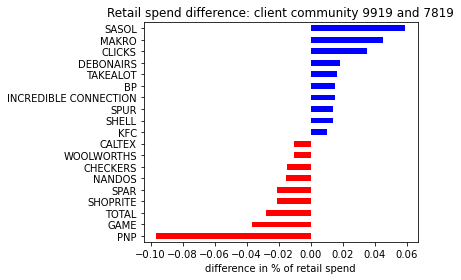

In [17]:
ax=gf[f]['9919_7819'].plot.barh(title='Retail spend difference: client community 9919 and 7819',
                               color=gf[f].positive.map({True: 'b', False: 'r'}))
ax.set_xlabel("difference in % of retail spend")
ax.set_ylabel("")
plt.tight_layout()
fig = ax.get_figure()
fig.savefig('/media/lnr-ai/christo/github_repos/graphing/img/9919_7819_signature_spend.png',dpi=100,bbox_inches='tight')

In [5]:
client_link_community_1904_df=graph.run(neo4j_query).to_data_frame()

In [ ]:
client_link_community_7916_list=list(client_link_community_7916_df.client_link_community_7916)

In [ ]:
client_link_community_7916_list

In [ ]:
community=822
graphname='triadic_graph_{community}'.format(community=community)
query="""CALL gds.graph.exists('{graphname}') YIELD exists;""".format(graphname=graphname)
exists=graph.run(query).data()
exists[0]['exists']

In [ ]:
create_graph_query = """CALL gds.graph.create.cypher(
    '{graphname}',
    'MATCH (c0:Client) WHERE c0.client_link_community_7916={community} RETURN id(c0) AS id',
    'MATCH (c0:Client)-[cl:CLIENT_LINK_7916]->(c1:Client) WHERE c0.client_link_community_7916={community} AND c1.client_link_community_7916={community} RETURN id(c0) AS source, id(c1) AS target, cl.count as count'
)
YIELD graphName, nodeCount, relationshipCount, createMillis;""".format(community=community,graphname=graphname)

In [ ]:
graph.run(create_graph_query).data()

In [ ]:
pagerank_query="""CALL gds.pageRank.stream('{graphname}', {{ maxIterations: 20, dampingFactor: 0.85 }})
YIELD nodeId, score
RETURN gds.util.asNode(nodeId).dedupestatic AS dedupestatic, nodeId AS nodeId, score
ORDER BY score DESC, dedupestatic ASC;""".format(graphname=graphname)

In [ ]:
gf=graph.run(pagerank_query).to_data_frame()

In [ ]:
gf

In [ ]:
list(client_link_community_7916_df)

In [ ]:
graph = Graph("bolt://localhost:7687", user='neo4j', password='newPassword')
hf=pd.DataFrame()
donelist=[]
leftoverlist=client_link_community_7916_list.copy()
counter=0
for community in client_link_community_7916_list:
    print('Doing community {community}, {counter} of {total}'.format(community=community,counter=len(donelist),total=len(client_link_community_7916_list)))
    graphname='triadic_graph_{community}'.format(community=community)
    query="""CALL gds.graph.exists('{graphname}') YIELD exists;""".format(graphname=graphname)
    exists=graph.run(query).data()
    if exists[0]['exists']:
        print("graph exists!")
        graph.run("""CALL gds.graph.drop('{graphname}') YIELD graphName;""".format(graphname=graphname)).data()
    #     CALL gds.graph.drop('my-store-graph') YIELD graphName;
    else:
        print("graph doesn't exist!")
    # ----------------------------------------------------------------------------
    create_graph_query = """CALL gds.graph.create.cypher(
        '{graphname}',
        'MATCH (c0:Client) WHERE c0.client_link_community_7916={community} RETURN id(c0) AS id',
        'MATCH (c0:Client)-[cl:CLIENT_LINK_7916]->(c1:Client) 
        WHERE c0.client_link_community_7916={community} AND 
        c1.client_link_community_7916={community} RETURN id(c0) AS source, id(c1) AS target, cl.count as count'
    )
    YIELD graphName, nodeCount, relationshipCount, createMillis;""".format(community=community,graphname=graphname)
    print('create graph {graphname}: '.format(graphname=graphname))
    graph.run(create_graph_query).data()
    print('Do page rank algorithm on {graphname}'.format(graphname=graphname))
    pagerank_query="""CALL gds.pageRank.stream('{graphname}', {{ maxIterations: 20, dampingFactor: 0.85 }})
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).dedupestatic AS dedupestatic, nodeId as nodeId, score
    ORDER BY score DESC, dedupestatic ASC;""".format(graphname=graphname)
    
    gf=graph.run(pagerank_query).to_data_frame()
    gf['community']=community
    gf['membercount']=list(client_link_community_7916_df[client_link_community_7916_df.client_link_community_7916==community]['membercount'])[0]
    gf.to_csv(path_or_buf='/media/lnr-ai/christo/github_repos/graphing/data/CLIENT_LINK_7916_{community}_df'.format(community=community),index=False) 
    hf = hf.append(gf, ignore_index=True)
    print(gf)
    print("Delete graph {graphname}...".format(graphname=graphname))
    graph.run("""CALL gds.graph.drop('{graphname}') YIELD graphName;""".format(graphname=graphname)).data()
#     print('-Sleep 60s---------------------------------')
#     time.sleep(60)
    donelist.append(community)
    leftoverlist.pop(leftoverlist.index(community))
    print(leftoverlist)
    counter+=1
    print("====================================================================================")

In [ ]:
# from py2neo import Graph
graph = Graph("bolt://localhost:7687", user='neo4j', password='newPassword')
hf=pd.DataFrame()
donelist=[]
tmp_list=leftoverlist.copy()
# leftoverlist=tmp_list
counter=0
for community in leftoverlist:
    print('Doing community {community}, {counter} of {total}'.format(community=community,counter=len(donelist),total=len(tmp_list)))
    # ----------------------------------------------------------------------------------------------------------    
    graphname='triadic_graph_{community}'.format(community=community)
    query="""CALL gds.graph.exists('{graphname}') YIELD exists;""".format(graphname=graphname)
    exists=graph.run(query).data()
    if exists[0]['exists']:
        print("graph exists!")
        graph.run("""CALL gds.graph.drop('{graphname}') YIELD graphName;""".format(graphname=graphname)).data()
    #     CALL gds.graph.drop('my-store-graph') YIELD graphName;
    else:
        print("graph doesn't exist!")
    # ----------------------------------------------------------------------------
    create_graph_query = """CALL gds.graph.create.cypher(
        '{graphname}',
        'MATCH (c0:Client) WHERE c0.client_link_community_7916={community} RETURN id(c0) AS id',
        'MATCH (c0:Client)-[cl:CLIENT_LINK_7916]->(c1:Client) 
        WHERE c0.client_link_community_7916={community} AND 
        c1.client_link_community_7916={community} RETURN id(c0) AS source, id(c1) AS target, cl.count as count'
    )
    YIELD graphName, nodeCount, relationshipCount, createMillis;""".format(community=community,graphname=graphname)
    graph.run(create_graph_query).data()

    pagerank_query="""CALL gds.pageRank.stream('{graphname}', {{ maxIterations: 20, dampingFactor: 0.85 }})
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).dedupestatic AS dedupestatic, nodeId as nodeId, score
    ORDER BY score DESC, dedupestatic ASC;""".format(graphname=graphname)

    gf=graph.run(pagerank_query).to_data_frame()
    gf['community']=community
    gf['membercount']=list(client_link_community_7916_df[client_link_community_7916_df.client_link_community_7916==community]['membercount'])[0]
    gf.to_csv(path_or_buf='/media/lnr-ai/christo/github_repos/graphing/data/CLIENT_LINK_7916_{community}_df'.format(community=community),index=False) 
    hf = hf.append(gf, ignore_index=True)
    print(gf)
    print("Delete graph {graphname}...".format(graphname=graphname))
    graph.run("""CALL gds.graph.drop('{graphname}') YIELD graphName;""".format(graphname=graphname)).data()
#     print('-Sleep 60s---------------------------------')
#     time.sleep(60)
    donelist.append(community)
    tmp_list.pop(tmp_list.index(community))
    print(tmp_list)
    counter+=1
    print("====================================================================================")

In [ ]:
tmp_list

In [ ]:
# from py2neo import Graph
graph = Graph("bolt://localhost:7687", user='neo4j', password='newPassword')
hf=pd.DataFrame()
donelist=[]
leftoverlist=tmp_list.copy()
# leftoverlist=tmp_list
counter=0
for community in leftoverlist:
    print('Doing community {community}, {counter} of {total}'.format(community=community,counter=len(donelist),total=len(tmp_list)))
    # ----------------------------------------------------------------------------------------------------------    
    graphname='triadic_graph_{community}'.format(community=community)
    query="""CALL gds.graph.exists('{graphname}') YIELD exists;""".format(graphname=graphname)
    exists=graph.run(query).data()
    if exists[0]['exists']:
        print("graph exists!")
        graph.run("""CALL gds.graph.drop('{graphname}') YIELD graphName;""".format(graphname=graphname)).data()
    #     CALL gds.graph.drop('my-store-graph') YIELD graphName;
    else:
        print("graph doesn't exist!")
    # ----------------------------------------------------------------------------
    create_graph_query = """CALL gds.graph.create.cypher(
        '{graphname}',
        'MATCH (c0:Client) WHERE c0.client_link_community_7916={community} RETURN id(c0) AS id',
        'MATCH (c0:Client)-[cl:CLIENT_LINK_7916]->(c1:Client) 
        WHERE c0.client_link_community_7916={community} AND 
        c1.client_link_community_7916={community} RETURN id(c0) AS source, id(c1) AS target, cl.count as count'
    )
    YIELD graphName, nodeCount, relationshipCount, createMillis;""".format(community=community,graphname=graphname)
    graph.run(create_graph_query).data()

    pagerank_query="""CALL gds.pageRank.stream('{graphname}', {{ maxIterations: 20, dampingFactor: 0.85 }})
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).dedupestatic AS dedupestatic, nodeId as nodeId, score
    ORDER BY score DESC, dedupestatic ASC;""".format(graphname=graphname)
    
    gf=graph.run(pagerank_query).to_data_frame()
    gf['community']=community
    gf['membercount']=list(client_link_community_7916_df[client_link_community_7916_df.client_link_community_7916==community]['membercount'])[0]
    gf.to_csv(path_or_buf='/media/lnr-ai/christo/github_repos/graphing/data/CLIENT_LINK_7916_{community}_df'.format(community=community),index=False) 
    hf = hf.append(gf, ignore_index=True)
    print(gf)
    print("Delete graph {graphname}...".format(graphname=graphname))
    graph.run("""CALL gds.graph.drop('{graphname}') YIELD graphName;""".format(graphname=graphname)).data()
#     print('-Sleep 60s---------------------------------')
#     time.sleep(60)
    donelist.append(community)
    tmp_list.pop(tmp_list.index(community))
    print(tmp_list)
    counter+=1
    print("====================================================================================")

In [ ]:
# path='/media/lnr-ai/christo/github_repos/graphing/data'
path='/media/lnr-ai/christo/github_repos/graphing/data'
file_list=glob.glob(path+'/*')
# df.append(ignore_index=)

In [ ]:
file_list

In [ ]:
answer_dict={}
answer_df=pd.DataFrame()
for file_name in file_list:
#     print(file_name)
    if 'CLIENT_LINK_7916' in file_name:
        print(file_name,int(file_name.split('_')[-2]))
        df=pd.read_csv(filepath_or_buffer=file_name)
#         answer_dict['franchisename_1']=df.iloc[0].franchisename
        answer_dict['dedupestatic']=df.iloc[0].dedupestatic

        answer_dict['nodeId']=df.iloc[0].nodeId           
        answer_dict['score']=df.iloc[0].score        
        answer_dict['community']=df.iloc[0].community       
        answer_dict['membercount']=df.iloc[0].membercount            
        answer_df=answer_df.append(answer_dict, ignore_index=True)

In [ ]:
answer_df

In [ ]:
print(file_name,int(file_name.split('_')[-2]))

In [ ]:
file_name.split('_')[-1]

In [ ]:
answer_df.to_csv('/media/lnr-ai/christo/github_repos/graphing/data/CLIENT_LINK_7916_pageranked.csv', index=False)

In [ ]:
answer_df=pd.read_csv('/media/lnr-ai/christo/github_repos/graphing/data/CLIENT_LINK_7916_pageranked.csv')

In [ ]:
neo4j_query="""MATCH (c:Client)-[t:TRANSACTED_AT]->(m:Merchant) WHERE m.subclass_id=56101
AND ID(c)=4636331.0 AND m.triadic_56101_community=7916 RETURN ID(c), t.transactionamount as transactionamount, 
t.transactioncount as transactioncount, 
m.franchisename as franchisename,
c.client_link_community_7916 as client_community,
m.triadic_56101_community as community;"""

In [ ]:
df=graph.run(neo4j_query).to_data_frame()

In [ ]:
df

In [ ]:
client_link_df=pd.DataFrame()
for nodeId in list(answer_df.nodeId):
    neo4j_query="""MATCH (c:Client)-[t:TRANSACTED_AT]->(m:Merchant) WHERE m.subclass_id=56101
AND ID(c)={nodeId} AND m.triadic_56101_community=7916 RETURN ID(c) as nodeId, t.transactionamount as transactionamount, 
t.transactioncount as transactioncount, 
m.franchisename as franchisename,
c.client_link_community_7916 as client_community,
m.triadic_56101_community as community;""".format(nodeId=nodeId)
    df=graph.run(neo4j_query).to_data_frame()
    print(df)
    client_link_df=client_link_df.append(df, ignore_index=True)

In [ ]:
client_link_df.sort_values('client_community',inplace = True)

In [ ]:
list(client_link_df)

In [ ]:
print(client_link_df[['nodeId',
#  'transactionamount',
#  'transactioncount',
 'franchisename',
 'client_community',]].to_latex(index=False))

In [ ]:
list(answer_df)

In [ ]:
hf=pd.DataFrame()
for nodeId in list(answer_df.community):
    neo4j_query="""
    MATCH (c:Client)-[t:TRANSACTED_AT]->(m:Merchant)
    WHERE EXISTS(c.client_link_community_7916) AND c.client_link_community_7916={nodeId} AND m.subclass_id=56101
    RETURN c.client_link_community_7916 AS client_link_community_7916,  
    m.franchisename as franchisename, 
    SUM(t.transactionamount) AS transactionamount, 
    SUM(t.transactioncount) AS transactioncount
    """.format(nodeId=nodeId)
    df=graph.run(neo4j_query).to_data_frame()
    print(df)
    hf = hf.append(df, ignore_index=True)

In [ ]:
hf.shape

In [ ]:
list(hf)

In [ ]:
sf=hf.pivot(index='client_link_community_7916', columns='franchisename', values='transactionamount')

In [ ]:
# sf.reset_index(inplace=True)
sf.fillna(0, inplace = True)

In [ ]:
sf.sum(axis=0)

In [ ]:
sf


In [ ]:
x=sf.iloc[0].to_numpy()

In [ ]:
x

In [ ]:
import numpy as np
np.argsort(x)

In [ ]:
list(sf)[476]

In [ ]:
np.argsort(x)[0:10]

In [ ]:
list(sf)[np.argsort(x)[0:10]]

In [ ]:
list(np.argsort(x)[0:10])

In [ ]:
s=list(sf)
s[np.argsort(x)[0:10]]

In [ ]:
d=np.argsort(x)[0:10]

In [ ]:
f=d.tolist()
x=sf.iloc[3].to_numpy()
[s[ind] for ind in np.argsort(x)[0:10]]

In [ ]:
x.sort()